In [1]:
import os

import findspark
findspark.init("/home/pc/TestJupyter/opt/spark-3.3.0/spark-3.3.0-bin-hadoop3")
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import HiveContext
from pyspark.sql import SparkSession
from pyspark.sql import Row


# warehouse_location points to the default location for managed databases and tables
os.environ["PYSPARK_PYTHON"]="/home/pc/TestJupyter/opt/spark-3.3.0/venv-spark/bin/python39"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.12:3.3.0  pyspark-shell'

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.driver.memory", "60g")\
    .config("spark.sql.warehouse.dir", "hdfs://10.123.51.78:8000/user/hive/warehouse") \
    .config("spark.sql.catalogImplementation", "hive")\
    .config("hive.metastore.uris", "thrift://g2.bigtop.it:9083")\
    .enableHiveSupport() \
    .getOrCreate()


def read_avro(path):
    return spark.read.format("avro").load(path)

def write_avro(df, path):
    return df.write.format("avro").save(path)

:: loading settings :: url = jar:file:/home/pc/TestJupyter/opt/spark-3.3.0/spark-3.3.0-bin-hadoop3/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/pc/.ivy2/cache
The jars for the packages stored in: /home/pc/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-73f6a8c6-5769-4c2e-8ea1-062a4a099db5;1.0
	confs: [default]
	found org.apache.spark#spark-avro_2.12;3.3.0 in central
	found org.tukaani#xz;1.8 in central
	found org.spark-project.spark#unused;1.0.0 in central
:: resolution report :: resolve 128ms :: artifacts dl 4ms
	:: modules in use:
	org.apache.spark#spark-avro_2.12;3.3.0 from central in [default]
	org.spark-project.spark#unused;1.0.0 from central in [default]
	org.tukaani#xz;1.8 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |

22/10/11 05:44:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/11 05:44:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/11 05:44:05 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
%load_ext autoreload
%autoreload 2
import connectPyspark as cp
from connectPyspark import *
import utilities as u
import shutil

22/10/05 22:42:24 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using state  server backend.


In [3]:
def clear_directory_but_keep_sample(path):
    write_avro(read_avro(path).sample(0.06).limit(1000), path+".sample")
    shutil.rmtree(path)
    spark.catalog.clearCache()

### STEP 1 : Data preprocessing for those token that will affected by the sentence tokenization
##### EMAIL : separated by dot
##### HTML  : inside might have dot
##### URL   : separated by dot

In [16]:
email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
def preprocess_for_token_with_dot_delimeter(df, col_name):
    return df.withColumn(col_name, regexp_replace(col_name, email_pattern, 'EMAIL')) \
             .withColumn(col_name, regexp_replace(col_name, r'http\S+', ''))         \
             .withColumn(col_name, regexp_replace(col_name, r'<[^>]+>', ''))  \
             .withColumn(col_name, regexp_replace(col_name, r'@[\w]+', 'ALIAS'))

In [2]:
df = read_avro("/home/pc/Assignment/Output/socialMedia.avro")
df = df.repartition(74)

In [3]:
df.count()

13615018

In [7]:
df.filter(df.Comment.rlike(f'http\S+|<[^>]+>|{email_pattern}')).show(100, False)


# 🆂🅰🅼🅿🅻🅴
### CLICK HERE TO SHOW BEFORE PREPROCESING I

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Comment                                                                                                                                                                                                                                                                                                     |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Perlukan LEBIH data?! Dapatkan pelan baharu dengan Social Tanpa Had + 2GB untuk RM10 selam

In [17]:
preprocessedI = preprocess_for_token_with_dot_delimeter(df, "Comment")
preprocessedI.filter(preprocessedI.Comment.rlike(f'http\S+|<[^>]+>|{email_pattern}')).show(100, False)


# 🆂🅰🅼🅿🅻🅴
### CLICK HERE TO SHOW DATA AFTER PREPROCESING I

+-------+
|Comment|
+-------+
+-------+



In [19]:
write_avro(preprocessedI, "output/1_preprocessedI")

In [40]:
spark.catalog.clearCache()

In [20]:
df = read_avro("output/1_preprocessedI")
df = df.repartition(74)
df = df.filter(df.Comment != "")

### STEP 2 : Sentence tokenization
##### tokenize it in three step targeted for english, chinese and malay
##### english = nltk
##### malay   = malaya
##### chinese = harvesttext

#### SPLITTING ENGLISH & MALAY SENTENCES

In [42]:
from nltk.tokenize import sent_tokenize
def get_sentenct_token(t):
    return sent_tokenize(t, "english")

engSentence = udf(lambda t:get_sentenct_token(t),ArrayType(StringType()))

def get_eng_senDF(df, coln):
    return df.withColumn(coln, engSentence(col(coln)))

In [34]:
sample = df.filter(df.Comment.contains("KUALA"))
sample.show(100, False)


# 🆂🅰🅼🅿🅻🅴
## CLICK HERE TO SHOW THE DATA THAT IS NOT SPLITTED BY SENTENCES

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from nltk.tokenize import sent_tokenize
def get_sentenct_token(t):
    return sent_tokenize(t, "english")

engSentence = udf(lambda t:get_sentenct_token(t),ArrayType(StringType()))

def get_eng_senDF(df, coln):
    return df.withColumn(coln, engSentence(col(coln)))

In [38]:
sample = get_eng_senDF(sample, "Comment")
df = get_eng_senDF(df, "Comment")

In [42]:
## flatmap back to 1d data
df= df.select(explode('Comment').alias('text')).drop("Comment")
sample= sample.select(explode('Comment').alias('text')).drop("Comment")



# 🆂🅰🅼🅿🅻🅴
### CLICK HERE TO SHOW THE TOKENIZED SENTENCES
sample.show(100, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### SPLITTING CHINESE SENTENCES

In [ ]:
from harvesttext import HarvestText
ht = HarvestText()

def chinese_para_to_sentence(text):
    return ht.cut_sentences(text)

getChiS = udf(lambda x : chinese_para_to_sentence(x), ArrayType(StringType()))


def get_df_chiSen(df, colname):
    return df.withColumn(colname, getChiS(col(colname)))

In [ ]:
sample = df.filter(df.text.contains("訊"))
sample.show(100, False)


# 🆂🅰🅼🅿🅻🅴
## CLICK TO SEE THE UNTOKENIZED CHINESE SENTENCES

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [49]:
from harvesttext import HarvestText
ht = HarvestText()

def chinese_para_to_sentence(text):
    return ht.cut_sentences(text)

getChiS = udf(lambda x : chinese_para_to_sentence(x), ArrayType(StringType()))


def get_df_chiSen(df, colname):
    return df.withColumn(colname, getChiS(col(colname)))

In [50]:
sample = get_df_chiSen(sample, "text")
df = get_df_chiSen(df, "text")

In [53]:
import pyspark.sql.functions as F

sample = sample.withColumn("text", F.explode(F.col('text')))
df= df.withColumn("text", F.explode(F.col('text')))


# 🆂🅰🅼🅿🅻🅴
## CLICK HERE TO SEE THE TOKENIZED CHINESE SENTENCES
sample.show(100, False)

+----------------------------------------------------------------------------------------------------------------+
|text                                                                                                            |
+----------------------------------------------------------------------------------------------------------------+
|多updated 資訊吧，1千初就有很好用的                                                                             |
|今天下午收到瑋瑋的語音訊息真的太開心，                                                                          |
|"致各國：廣傳我現每次貼文要3小時或以上，很累！                                                                  |
|能否大家Line群組，接到訊息就分享？                                                                              |
|(1).…                                                                                                           |
|就如同印度黴菌/兒童肝炎/猴痘/重覆感染等等，均因新冠消化很多能量，導致其他菌病毒有機會冒出。                     |
|這就是我為何強調要食療！                                                                 

In [48]:
write_avro(df, "output/2_split")

### STEP 3 : Data preprocessing that is independent from the languages
- emoji
- linebreaks
- alias
- phone
- key value
- hashtag
- extraspaces
- null value

In [30]:
import contractions
from connectPyspark import *
from pyspark.sql.functions import sentences, lit, flatten
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql.functions import col, udf, size, split
import chinese_converter
from cleantext import clean

def remove_contractions(text):
    return contractions.fix(text)

noContr = udf(lambda x : remove_contractions(x), StringType())
linebreak_pattern = r"((\r\n\t)|[\n\v\t])+"
email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
phone_pattern = r"((?:^|(?<=[^\w)]))(((\+?[01])|(\+\d{2}))[ .-]?)?(\(?\d{3,4}\)?/?[ .-]?)?(\d{3}[ .-]?\d{4})(\s?(?:ext\.?|[#x-])\s?\d{2,6})?(?:$|(?=\W)))|\+?\d{4,5}[ .-/]\d{6,9}"
number_pattern = r"(?:^|(?<=[^\w,.]))[+–-]?(([1-9]\d{0,2}(,\d{3})+(\.\d*)?)|([1-9]\d{0,2}([ .]\d{3})+(,\d*)?)|(\d*?[.,]\d+)|\d+)(?:$|(?=\b))"
key_pattern = r"(\w+)(?=:):"
num = "[0-9]"
symbols = """☺|☻|\||\/|♥|\[|♦|♣|\.|♠|•|◘|○|◙|♂|♀|♪|♫|☼|►|◄|↕|‼|¶|\$|§|▬|↨|↑|↓|→|←|∟|↔|▲|▼|#|%|&|,|-|\'|:|;|<|=|>|@|]|_|`|¢|£|¥|₧|ƒ|ª|º|¿|⌐|¬|½|¼|¡|«|»|░|▒|▓|│|┤|╡|╢|╖|╕|╣|║|╗|╝|╜|╛|┐|└|┴|┬|├|─|┼|╞|╟|╚|╔|╩|╦|╠|═|╬|╧|╨|╤|╥|╙|╘|╒|╓|╫|╪|┘|┌|█|▄|▌|▐|▀|α|ß|Γ|π|Σ|σ|µ|τ|Φ|Ω|δ|∞|φ|ε|∩|≡|±|≥|≤|⌠|⌡|÷|≈|°|\+|∙|·|√|ⁿ|\)|\(|²|■|\~|\.|\?|\*|\!|\✓|\^|？|｡|\。|\|:|;|＂"""


def clean_punctuations(text):
    return clean(fix_unicode=True, no_punct=True)

def simplifiy_chinese(text):
    return chinese_converter.to_simplified(text)

def preprocessing(df, col_name):
    return  \
    df.withColumn(col_name, F.lower(col(col_name)))\
    .withColumn(col_name, F.regexp_replace(col_name, linebreak_pattern, '')) \
    .withColumn(col_name, F.regexp_replace(col_name, r'@[\w]+', 'ALIAS'))\
    .withColumn(col_name, F.regexp_replace(col_name, phone_pattern, 'PHONE'))\
    .withColumn(col_name, F.regexp_replace(col_name, key_pattern, '')) \
    .withColumn(col_name, F.regexp_replace(col_name, "#([a-zA-Z0-9_]{1,50})",''))\
    .withColumn(col_name, F.regexp_replace(col_name, r'\s+', ' ')) \
    .withColumn(col_name, F.regexp_replace(col_name, num, '')) \
    .withColumn(col_name, noContr(F.col(col_name))) \
    .filter( (df[col_name] != "") | (df[col_name] != None)) \
    .withColumn(col_name, sentences(F.col(col_name))) \
    .select(flatten(F.col(col_name)).alias('text')) \
    .rdd.map(lambda x : (" ".join(x.text), 1)).toDF(["text","id"]).drop("id") \
    .withColumn(col_name, F.regexp_replace(col_name, symbols, ''))



In [31]:
df = read_avro("output/2_split_MCOST")
df = df.repartition(74)

In [32]:
write_avro(preprocessing(df, "text"), "output/3_LIPP")

In [21]:
df = read_avro("output/3_LIPP")
df.show(100, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                          |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|the parcels have arrived safely                                                                                                                                                     

### STEP 4 : Language Detection For Sentences (Costly)

In [38]:
spark.catalog.clearCache()

In [24]:
spark.catalog.clearCache()
df = read_avro("output/3_LIPP")
df = df.repartition(74)

In [ ]:
from pyspark.sql.functions import col, udf
from lingua import Language, LanguageDetectorBuilder
languages = [Language.ENGLISH, Language.CHINESE, Language.MALAY]


nonDistDetector = LanguageDetectorBuilder.from_languages(*languages).build()
withDistDetector = LanguageDetectorBuilder.from_languages(*languages).with_minimum_relative_distance(0.05).build()


def lingua_detect_dist(text):
    global withDistDetector

    try:
        if (withDistDetector == None):
            withDistDetector = LanguageDetectorBuilder.from_languages(*languages).with_minimum_relative_distance(0.05).build()
        return str(withDistDetector.detect_language_of(text))
    
    except:
        return "error"

def lingua_detect(text):
    global nonDistDetector
    
    try:
        if (nonDistDetector == None):
            nonDistDetector = LanguageDetectorBuilder.from_languages(*languages).build()
        return str(nonDistDetector.detect_language_of(text))
    except:
        return "error"    

detectWithDistUDF = udf(lambda z: lingua_detect_dist(z))
detectUDF = udf(lambda z: lingua_detect(z))

In [26]:
df = df.filter(df.text != "")
df = df.withColumn("lang", detectUDF(F.col("text"))) ## detectUDF is custom made UDF

In [4]:
# 🆂🅰🅼🅿🅻🅴
### CLICK HERE TO SHOW DATA AFTER LANGUAGES DETECTION
spark.read.format("avro").load("output/4_CommentWithLanguage_COST").show(100, False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+
|text                                                                                                                                                                                                      |lang            |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+
|thankyouuuu thankyouuu thankyouuu thankyouuuuu thankyouuuuu                                                                                                                                               |Language.ENGLISH|
|selipar dah sampai saiz btol ngam kalau ukur ikut size chart tu                                                

In [46]:
write_avro(df, "output/4_CommentWithLanguage_COST")

In [ ]:
clear_directory_but_keep_sample("output/2_split")

### MISSING STEP : NORMALIZE CHINESE

In [59]:
df = read_avro("output/4_CommentWithLanguage_COST")
df = df.filter(df.text != "")

In [60]:
import chinese_converter
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql.functions import col, udf, size, split

def simplifiy_chinese(text):
    return chinese_converter.to_simplified(text)

udfSimpChinese = udf(lambda x : simplifiy_chinese(x), StringType())

In [61]:
df = df.withColumn("text", udfSimpChinese(F.col("text")))

In [62]:
write_avro(df, "output/4_CommentWithLanguage_COST_B")

In [5]:
import pyspark.sql.functions as F

In [11]:
spark.read.format("avro").load("/home/pc/Assignment/Output/socialMedia.avro").filter(F.col("Comment").contains("中國")).show(100, False)
spark.read.format("avro").load("output/4_CommentWithLanguage_COST").filter(F.col("text").contains("中國")).show(100, False)


# 🆂🅰🅼🅿🅻🅴
### CLICK HERE TO SHOW DATA AFTER SIMPLIFIED CHINESE

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Comment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
+-------------------------------------

### STEP 5 : Classify the dataframe accoring to language
- Know what language are detected
- Know their distribution

In [12]:
def get_all_type_of_languages_detected(df, col_name):
    return df.select(df[col_name]).distinct().rdd.flatMap(lambda x : x).collect()

def map_language_with_its_dataframe(lang_arr, df, col_name):
    temp_map = {}
    for lang in lang_arr:
        temp_map[lang] = df.filter( df[col_name] == lang)
    return temp_map

class LanguageAggregor:
    def __init__(self, df, col_name):
        self.col_name = col_name
        self.df = df
        self.all_language = get_all_type_of_languages_detected(df, self.col_name)
        self.lang_df_map = map_language_with_its_dataframe(self.all_language, self.df, self.col_name)

    def print_available_lang(self):
        print(self.all_language)
        
    def get_lang_dataframe(self, lang):
        return self.lang_df_map[lang]
    
    def show_sample(self, sample_size):
        for lang in self.all_language:
            print("This is dataframe of lang ", lang)
            self.lang_df_map[lang].show(sample_size, False)

In [15]:
df = read_avro("output/4_CommentWithLanguage_COST")

In [ ]:
agg = LanguageAggregor(df, "lang")

In [17]:
agg.all_language

['None', 'Language.ENGLISH', 'Language.MALAY', 'Language.CHINESE']

In [66]:
for lang in agg.all_language:
    agg.get_lang_dataframe(lang).show(100, False)


    
# 🆂🅰🅼🅿🅻🅴
### CLICK HERE TO SHOW HOW THE LINGUA CLASSIFY THE SENTENCES INTO NONE, ENGLISH AND MALAY CHINESE

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|text                                                                                                                                                                                                                                                                                                       |lang|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|ван несс не плохой пареньинтелегентный культурный большой профи предан своему 

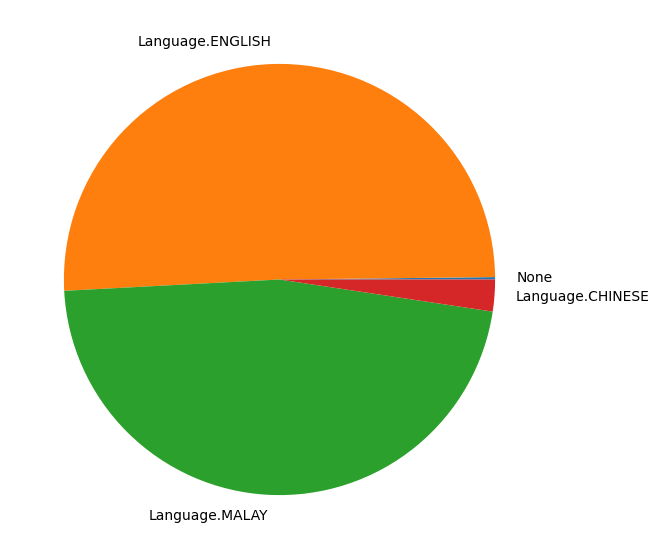

In [67]:
from matplotlib import pyplot as plt
import numpy as np
def draw_pie(cake, count): 
    fig = plt.figure(figsize =(10, 7))
    plt.pie(count, labels = cake)
    plt.show()


l = [x for x in agg.all_language]
v = [agg.get_lang_dataframe(x).count() for x in agg.all_language]

draw_pie(l, v)

In [68]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

write_avro(
    unionAll(
    agg.get_lang_dataframe('Language.ENGLISH'),
    agg.get_lang_dataframe('Language.MALAY'),
    agg.get_lang_dataframe('Language.CHINESE')
    ),
    "output/5_BI_BC_BM_B.avro",
)

22/10/04 21:12:56 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-05e231c2-8b52-4002-ad0b-7c4cb4a2c771. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-05e231c2-8b52-4002-ad0b-7c4cb4a2c771
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:171)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:110)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:91)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1206)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:374)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:370)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 46360)
Traceback (most recent call last):
  File "/opt/python39/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/python39/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/python39/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/python39/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/pc/TestJupyter/opt/spark-3.3.0/spark-3.3.0-bin-hadoop3/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/home/pc/TestJupyter/opt/spark-3.3.0/spark-3.3.0-bin-hadoop3/python/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/home/pc/TestJupyter/opt/spark-3.3.0/spark-3.3.0-bin